## GRU CNN model on HAR task

This tutorial will create a tf-lite model for further deployment on a HAR app. The model classifies the activity of a subject wearing a Respeck sensor with 2 second latentcy.
Load tensorflow keras package for creating the model.

In [294]:
import pandas as pd
import numpy as np

import tensorflow as tf
import seaborn as sns


# keras goodies
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras import optimizers

from tensorflow import keras
from pylab import rcParams
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import classification_report
import glob
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Load data collected by Respeck sensor from students to a `base_df` dataframe.

In [295]:
#raw_data_folder = ('./raw_data/Respeck_recordings_clean.csv')
raw_data_folder = (glob.glob('./raw_data/**/*.csv', recursive=True))
for filename in raw_data_folder[:]:
    if 'Thingy' in filename:
        raw_data_folder.remove(filename)
    else:
        continue
base_df = pd.DataFrame()

for filename in raw_data_folder:
    # print(filename)
    # load data into a DataFrame
    new_df = pd.read_csv(filename)
    
    # merge into the base DataFrame
    base_df = pd.concat([base_df, new_df])
base_df.reset_index(drop=True, inplace=True)

# # load concanated data instead
#base_df = pd.read_csv(raw_data_folder, encoding='utf-8', delimiter=',')
#base_df.reset_index(drop=True, inplace=True)
base_df.columns

Index(['timestamp', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y',
       'gyro_z', 'sensor_type', 'activity_type', 'activity_code', 'subject_id',
       'notes', 'recording_id', 'Unnamed: 0', 'Unnamed: 0.1'],
      dtype='object')

Delete augmented index rows due to DataFrame conanation and drop null data.

In [296]:
base_df = base_df.loc[:, ~base_df.columns.str.match('Unnamed')]
base_df.drop(columns=['notes'], inplace=True, axis=1)
base_df.dropna(inplace= True)
# df1 = base_df[base_df.isna().any(axis=1)]

Match Class labels from 18 class to grouped 5 class. 

In [297]:
class_labels = {
    'Descending stairs': None,
    'Running': 'Running',
    'Climbing stairs': None,
    'Walking at normal speed': 'Walking',
    'Lying down on back': 'Lying down',
    'Desk work': None,
    'Sitting bent backward': None,
    'Lying down right': "Lying down",
    'Lying down on stomach': 'Lying down',
    'Lying down left': 'Lying down',
    'Falling on the left': 'Falling',
    'Movement': None,
    'Standing': 'Standing/Sitting',
    'Sitting': 'Standing/Sitting',
    'Falling on knees': 'Falling',
    'Falling on the back': 'Falling',
    'Sitting bent forward': 'Falling',
    'Falling on the right': 'Falling',
}
base_df['activity_type'].replace(class_labels,inplace = True)
base_df = base_df[base_df.activity_type.notnull()]
base_df.reset_index(drop=True, inplace=True)
base_df['activity_type'].unique()


array(['Standing/Sitting', 'Falling', 'Lying down', 'Walking', 'Running'],
      dtype=object)

Check the amount of data in each class.

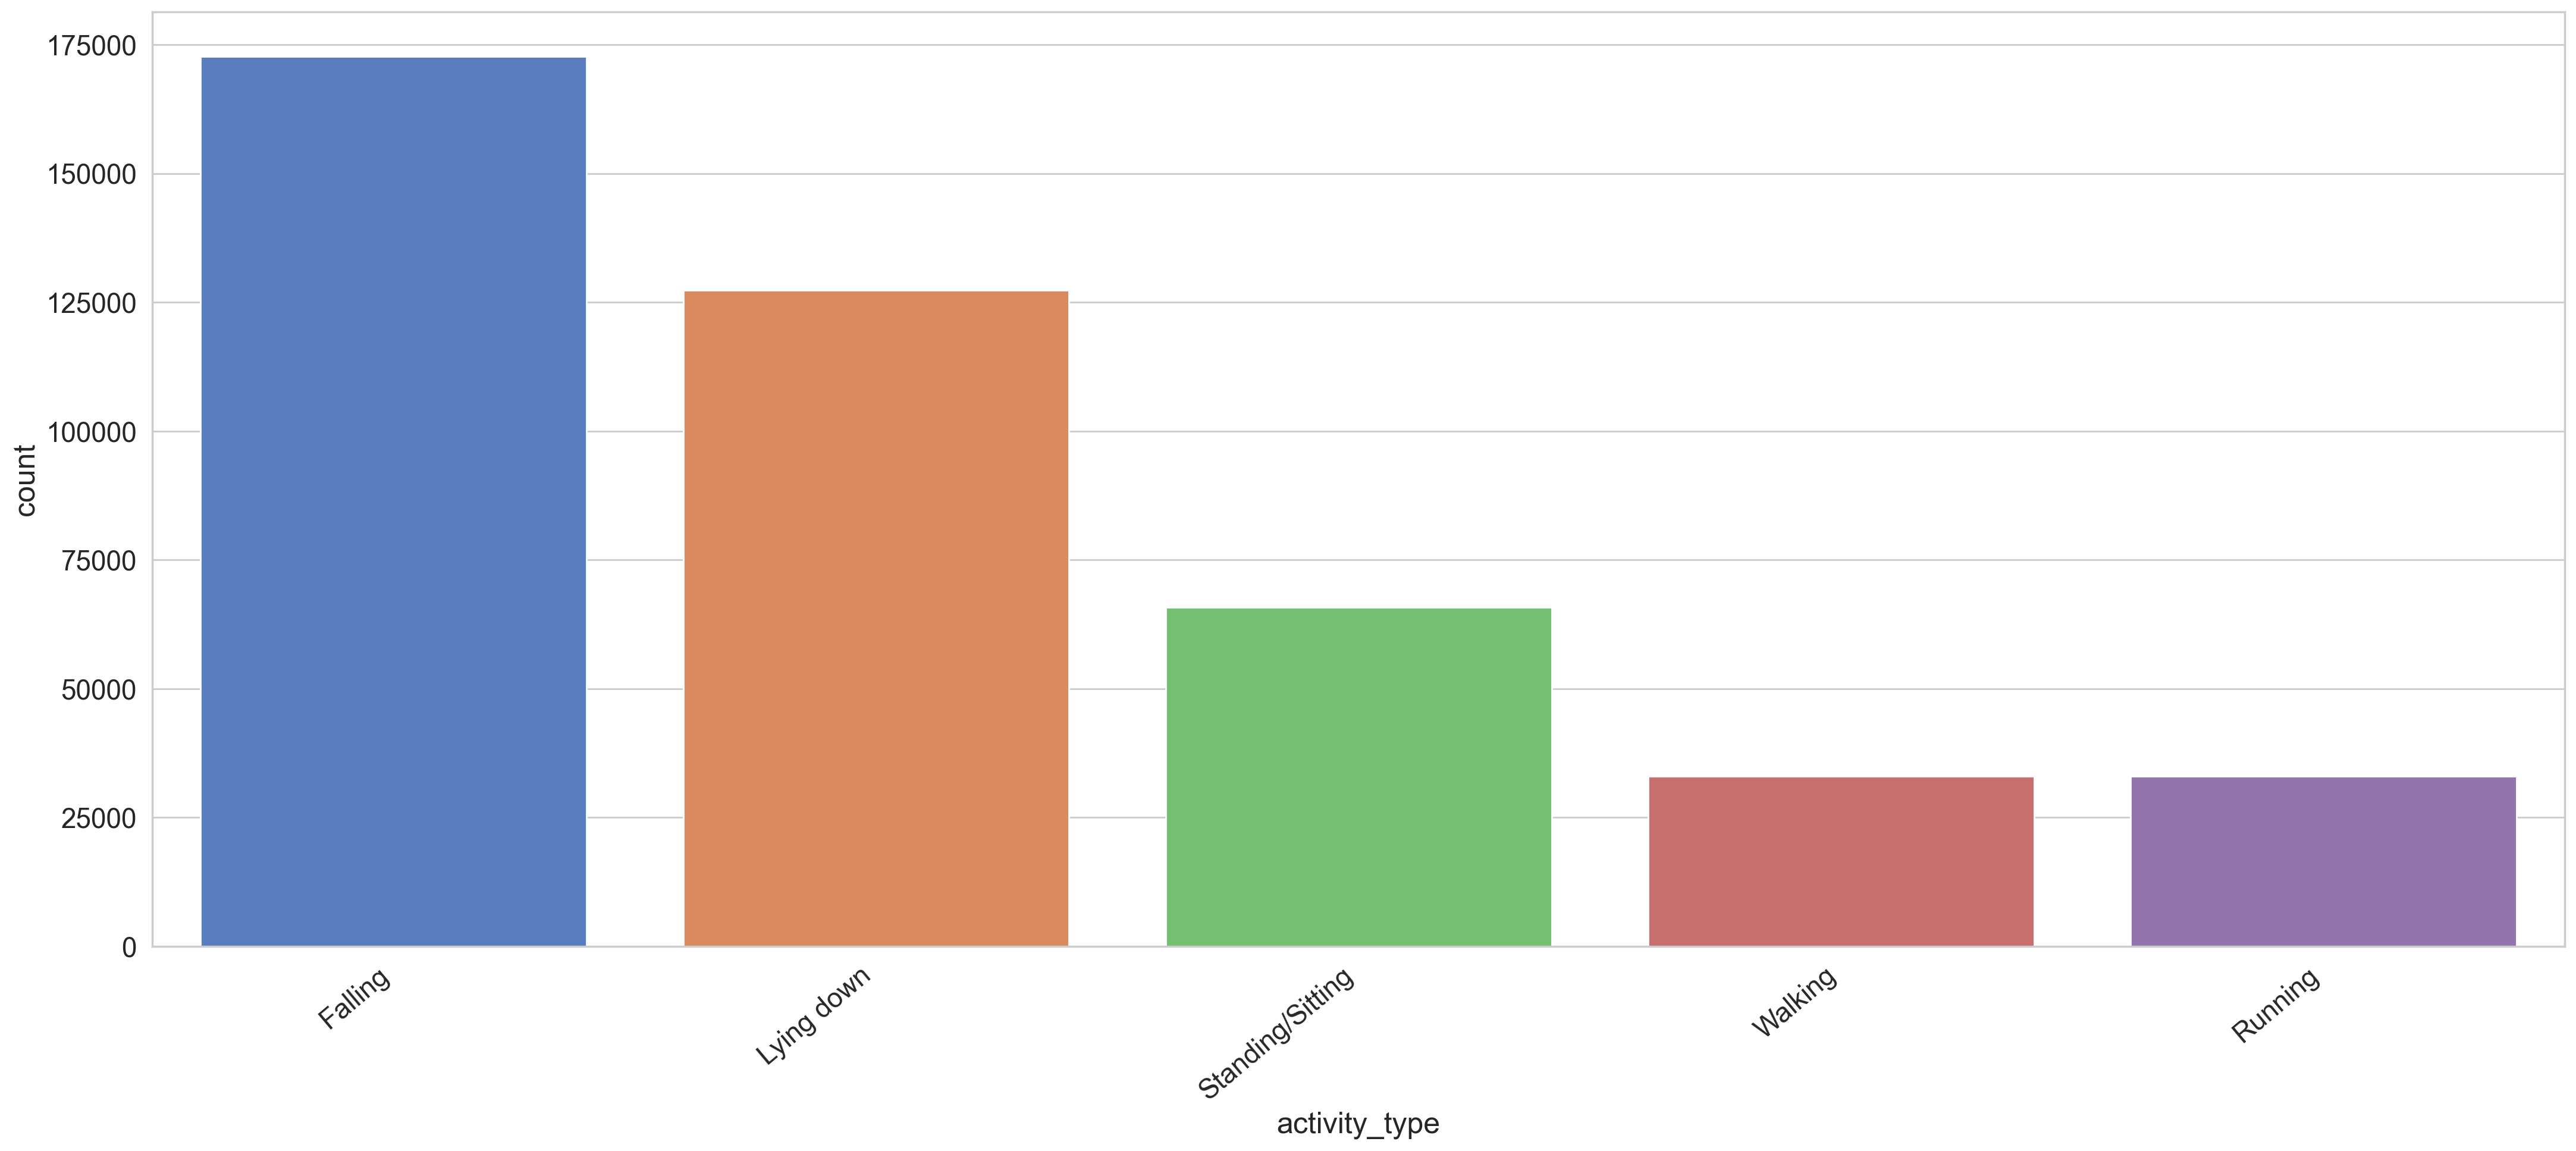

In [298]:
ax = sns.countplot(x = 'activity_type',
              data = base_df,
              order = base_df.activity_type.value_counts().index)


ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = "right")
plt.tight_layout()
plt.show()

Check the amount of data recorded from each individual subject. Each subject should have 18 recordings in principle, some data are dropped due to mis-recordings.

Text(0.5, 1.0, 'Records per subject')

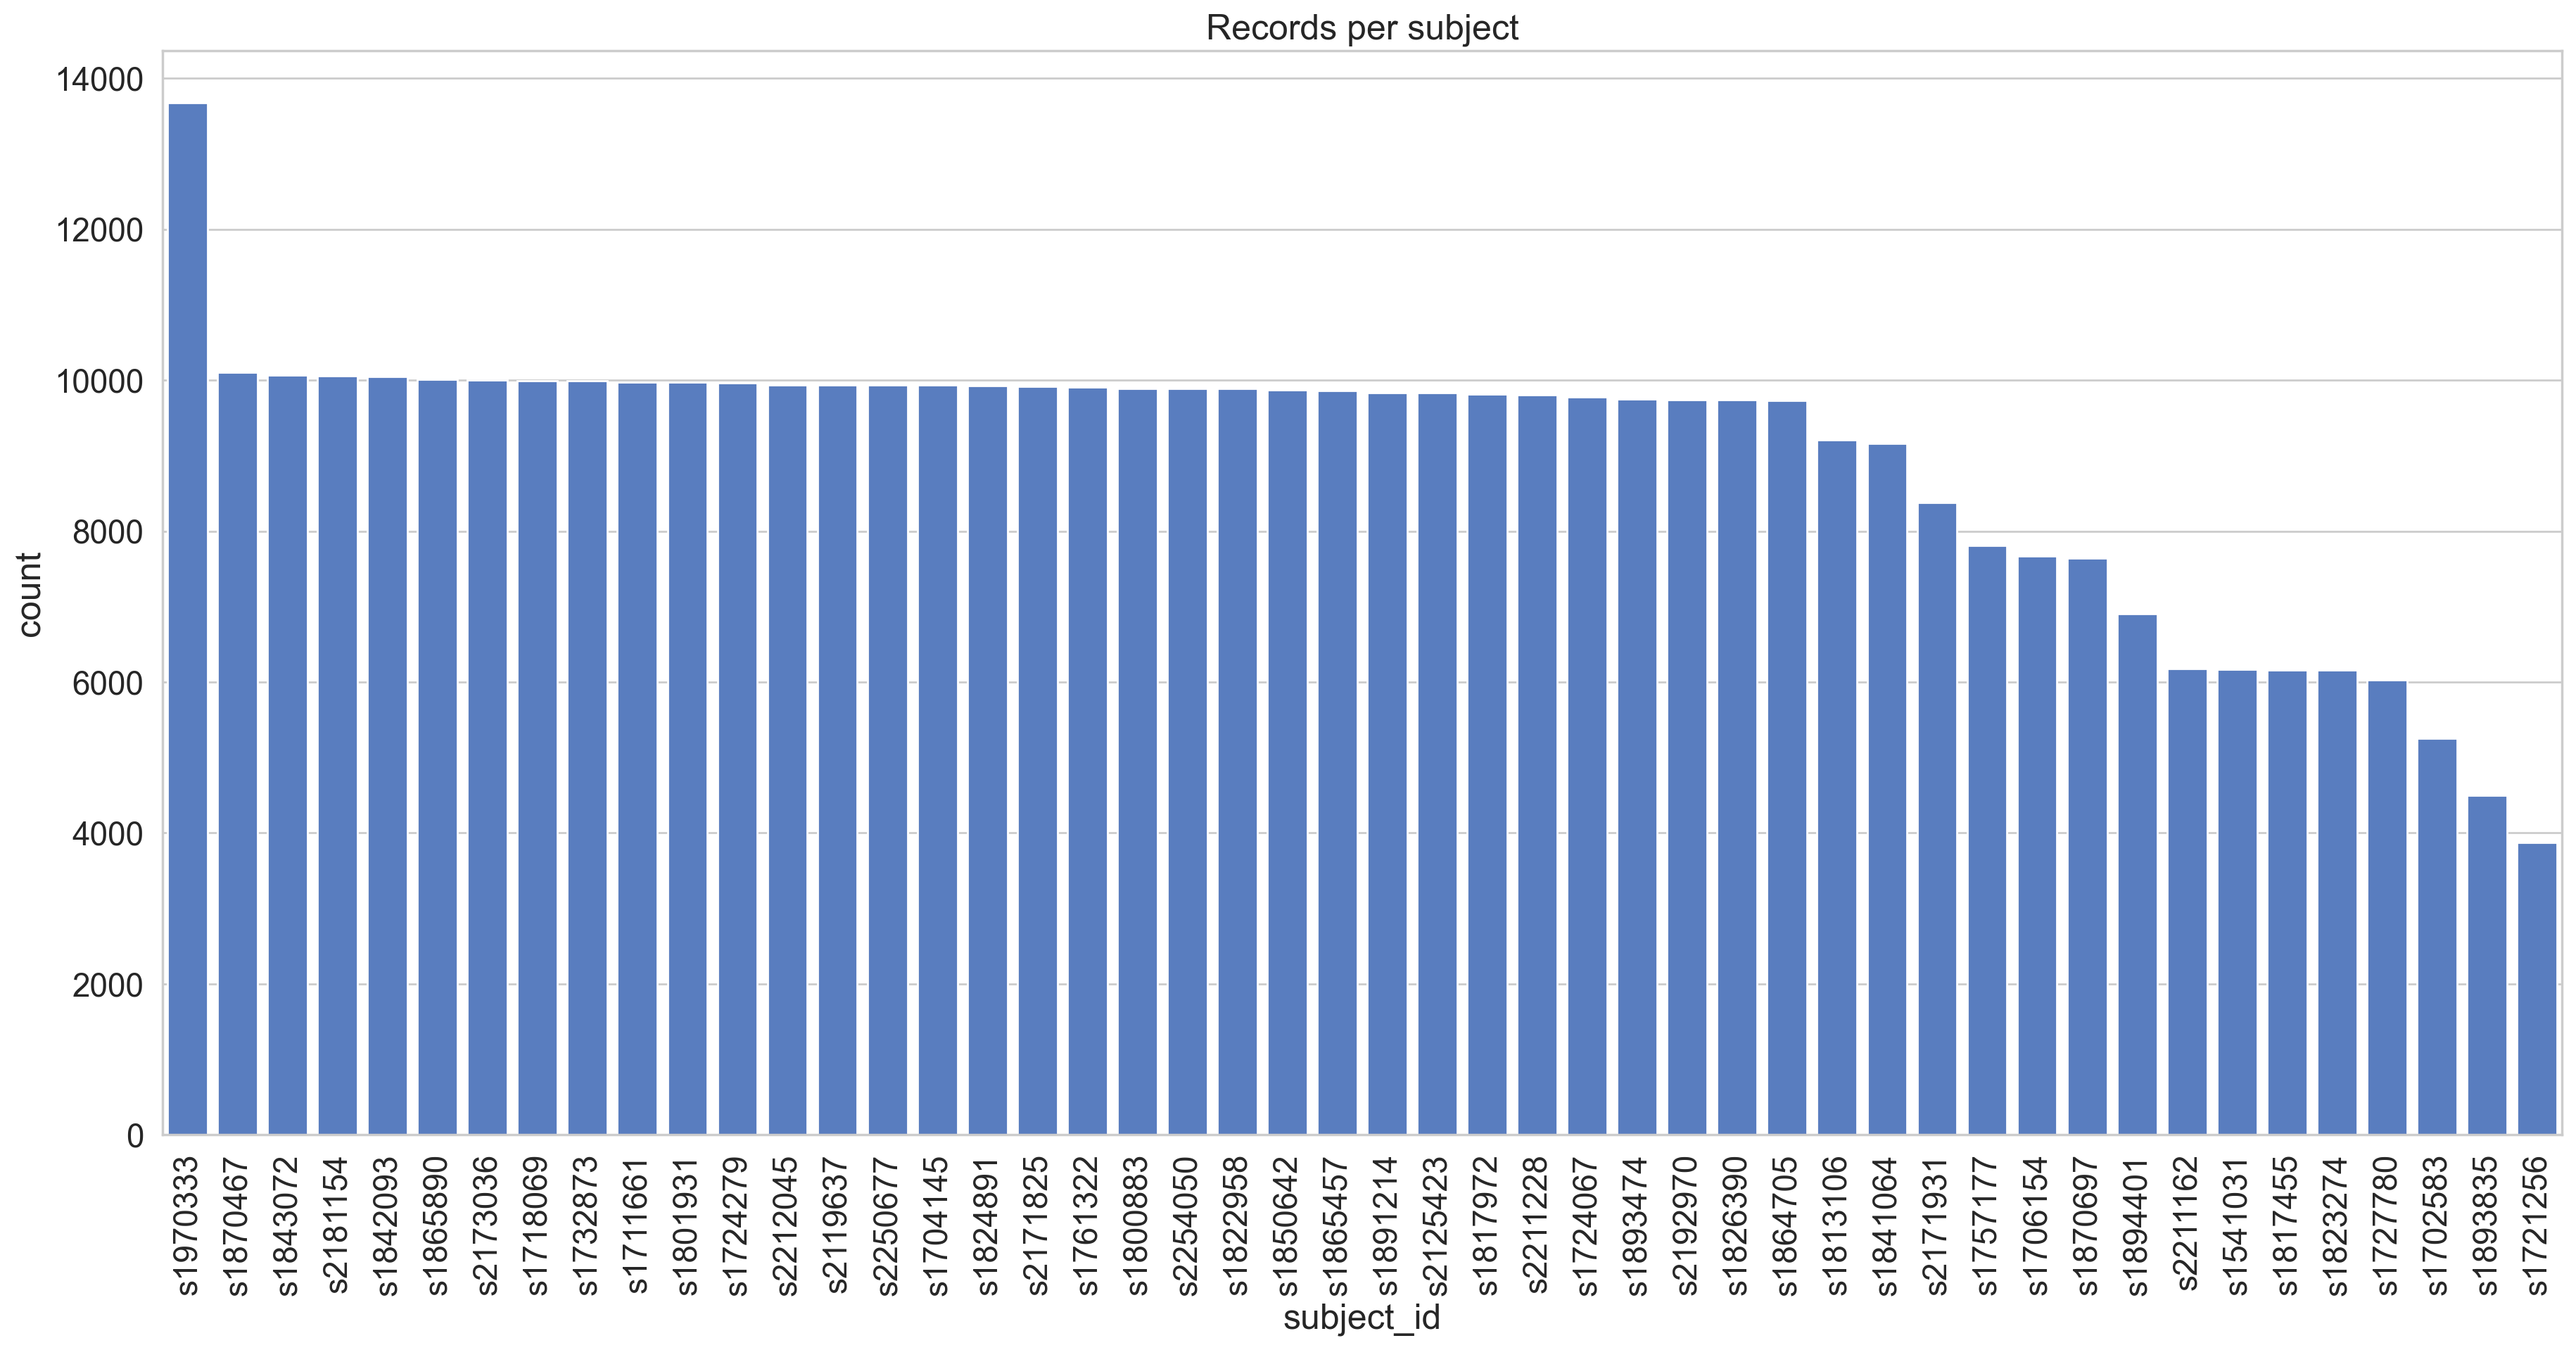

In [299]:
ax = sns.countplot(x = 'subject_id',
              data = base_df,
              palette=[sns.color_palette()[0]],
              order = base_df.subject_id.value_counts().index)
ax.set_xticklabels(labels= ax.get_xticklabels(),rotation=90)
plt.title("Records per subject")

Segment recordings to overlapped sliding windows, discard recordings less than 2s (50Hz)

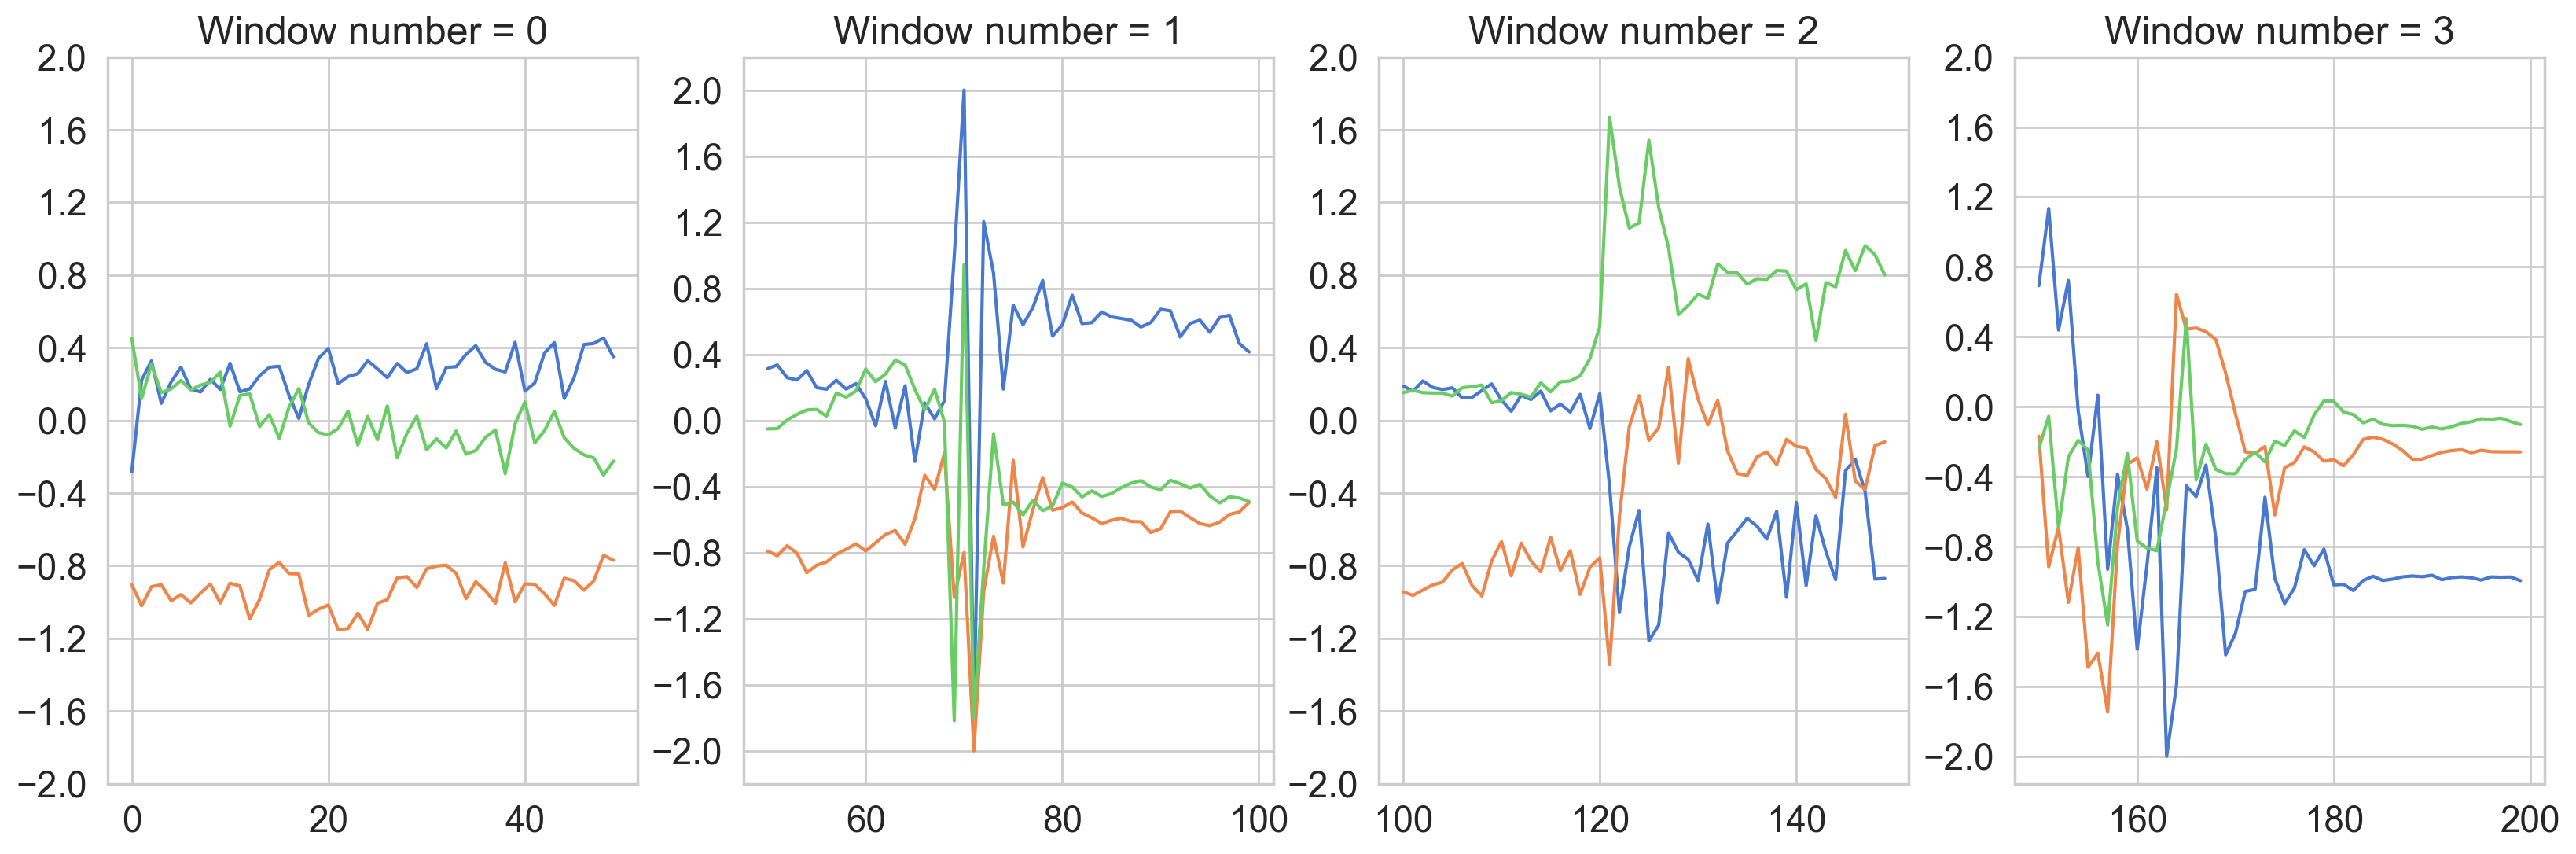

In [300]:
# recordings with different recording ID are recorded in different trails 
# fallings are recorded seprately and concanated together, each falling should lasts longer than 2s
example_recording = base_df.groupby(['recording_id'], as_index=False)

#example_recording

window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # 25 this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

# for each data chunk belongs to a unique recording id, get overlapped winodws of this data chunk
large_enough_windows = [window for window in example_recording.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

overlapping_windows = large_enough_windows[::step_size] 

for window in overlapping_windows:
    window.loc[:, 'window_id'] = window_number
    window_number += 1

final_sliding_windows = pd.concat(overlapping_windows).reset_index(drop=True)

# plot the fist 4 overlapping windows (the 4 windows may not actually overlap if they are falling data where each recording is short (<3s))
first_four_windows = [group for _, group in final_sliding_windows[final_sliding_windows.window_id < 4].groupby("window_id")]

fig, ax = plt.subplots(1, 4, figsize=(20, 6))

# for i in range(4):
#     ax[i].plot(first_four_windows[i]['gyro_x'])
#     ax[i].plot(first_four_windows[i]['gyro_y'])
#     ax[i].plot(first_four_windows[i]['gyro_z'])
#     ax[i].set_title(f"Window number = {first_four_windows[i].window_id.values[0]}")

for i in range(4):
    ax[i].plot(first_four_windows[i]['accel_x'])
    ax[i].plot(first_four_windows[i]['accel_y'])
    ax[i].plot(first_four_windows[i]['accel_z'])
    ax[i].set_yticks(np.linspace(-2,2,11))
    ax[i].set_title(f"Window number = {first_four_windows[i].window_id.values[0]}")


In [301]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [302]:
window_id_class_labels = final_sliding_windows.groupby(["window_id",'subject_id'])[['activity_type']].agg(np.min)
window_id_class_labels = window_id_class_labels.reset_index()
base_train_df = window_id_class_labels.join(base_df[columns_of_interest])

Split sliding windows into Training set, testing set and validation set.

In [303]:
#split train and test by subject
def train_test_split(df, split_col, test_fraction):
    split_values = df[split_col].drop_duplicates()
    test_values = split_values.sample(frac=test_fraction, random_state=42)
    
    df_test = df[df[split_col].isin(test_values)]
    df_train = df[~df[split_col].isin(test_values)]
    return df_test, df_train

In [304]:
df_test,df_train=train_test_split(base_train_df,'subject_id',0.2)

In [305]:
df_validation,df_train=train_test_split(df_train,'subject_id',0.05)

In [306]:
print(f"The data was collected for the activities in test set: {df_test.activity_type.unique()}")
print(f"The subject IDs in test set are: {len(df_test.subject_id.unique())}")
print(f"The data was collected for the activities in train set: {df_train.activity_type.unique()}")
print(f"The subject IDs in the train set are: {len(df_train.subject_id.unique())}")
print(f"The data was collected for the activities in val set: {df_validation.activity_type.unique()}")
print(f"The subject IDs in val set are: {len(df_validation.subject_id.unique())}")

The data was collected for the activities in test set: ['Falling' 'Lying down' 'Running' 'Standing/Sitting' 'Walking']
The subject IDs in test set are: 10
The data was collected for the activities in train set: ['Falling' 'Lying down' 'Walking' 'Running' 'Standing/Sitting']
The subject IDs in the train set are: 36
The data was collected for the activities in val set: ['Lying down' 'Running' 'Falling' 'Standing/Sitting' 'Walking']
The subject IDs in val set are: 2


convert sliding windows into Tensor-like shapes 

In [307]:
X = []
y = []

for window_id, group in final_sliding_windows.groupby('window_id'):    
    shape = group[columns_of_interest].values.shape    
    X.append(group[columns_of_interest].values)
    y.append(group["activity_type"].values[0])

X = np.asarray(X)
y = np.asarray(y)
print(f"X shape = {X.shape}")
print(f"y shape = {y.shape}")

X shape = (11863, 50, 6)
y shape = (11863,)


In [308]:
X_train=X[df_train.index]
y_train=y[df_train.index]

X_test=X[df_test.index]
y_test=y[df_test.index]

X_validation=X[df_validation.index]
y_validation=y[df_validation.index]

convert y from integer into one hot encodings 

In [309]:
y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)
y_validation = np.asarray(pd.get_dummies(y_validation), dtype=np.float32)

In [310]:
print(f"X_train shape = {X_train.shape}")
print(f"y_train shape = {y_train.shape}")

print(f"X_test shape = {X_test.shape}")
print(f"y_test shape = {y_test.shape}")

print(f"X_validation shape = {X_validation.shape}")
print(f"y_validation shape = {y_validation.shape}")

X_train shape = (8789, 50, 6)
y_train shape = (8789, 5)
X_test shape = (2558, 50, 6)
y_test shape = (2558, 5)
X_validation shape = (516, 50, 6)
y_validation shape = (516, 5)


## GRU
Fit the GRU model, loss measured by cross-entroy.

In [311]:
filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 5
hidden_units = 64
time_steps = 5

In [312]:
from tensorflow.keras.layers import GRU
from keras.models import Sequential
from keras.layers import (
    LSTM,
    Bidirectional,
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Activation,
    Dropout,
    BatchNormalization
)
model = Sequential()
# model can be easily overfitting, therefore define a bigger dropout
model.add(GRU(128,input_shape=[50,6],dropout=0.2,use_bias=True,return_sequences=True,activation='tanh'))
model.add(GRU(64, use_bias=True, dropout=0.2,activation='relu'))
#model.add(BatchNormalization())
#model.add(Flatten())
#model.add(Dense(28, activation='relu'))
model.add(Dense(n_classes,activation='softmax'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 50, 128)           52224     
                                                                 
 gru_25 (GRU)                (None, 64)                37248     
                                                                 
 dense_30 (Dense)            (None, 5)                 325       
                                                                 
Total params: 89,797
Trainable params: 89,797
Non-trainable params: 0
_________________________________________________________________


In [313]:
optim = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'] )

In [314]:
# early terminate if did not see impovement on accuracy of validation set in 50 epochs

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=30)
history = model.fit(X_train, y_train,batch_size=256, epochs=100,callbacks=[callback],
                    validation_data=(X_validation, y_validation))


Epoch 1/100
35/35 [==============================] - 8s 159ms/step - loss: 1.5714 - accuracy: 0.3217 - val_loss: 1.5061 - val_accuracy: 0.3837
Epoch 2/100
35/35 [==============================] - 5s 148ms/step - loss: 1.4302 - accuracy: 0.5422 - val_loss: 1.3976 - val_accuracy: 0.4574
Epoch 3/100
35/35 [==============================] - 5s 156ms/step - loss: 1.2927 - accuracy: 0.6319 - val_loss: 1.2766 - val_accuracy: 0.6686
Epoch 4/100
35/35 [==============================] - 5s 145ms/step - loss: 1.1249 - accuracy: 0.6933 - val_loss: 1.1159 - val_accuracy: 0.6570
Epoch 5/100
35/35 [==============================] - 6s 170ms/step - loss: 0.9360 - accuracy: 0.7286 - val_loss: 0.9295 - val_accuracy: 0.7171
Epoch 6/100
35/35 [==============================] - 5s 142ms/step - loss: 0.7137 - accuracy: 0.7836 - val_loss: 0.6455 - val_accuracy: 0.8391
Epoch 7/100
35/35 [==============================] - 5s 143ms/step - loss: 0.4593 - accuracy: 0.8414 - val_loss: 0.4060 - val_accuracy: 0.8585

Test GRU model and get classification report on testing set.

In [315]:
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

80/80 [==============================] - 1s 9ms/step


In [316]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       521
           1       0.97      0.94      0.96       991
           2       0.94      1.00      0.97       283
           3       0.83      1.00      0.91       507
           4       1.00      0.91      0.95       256

    accuracy                           0.93      2558
   macro avg       0.93      0.93      0.93      2558
weighted avg       0.93      0.93      0.93      2558



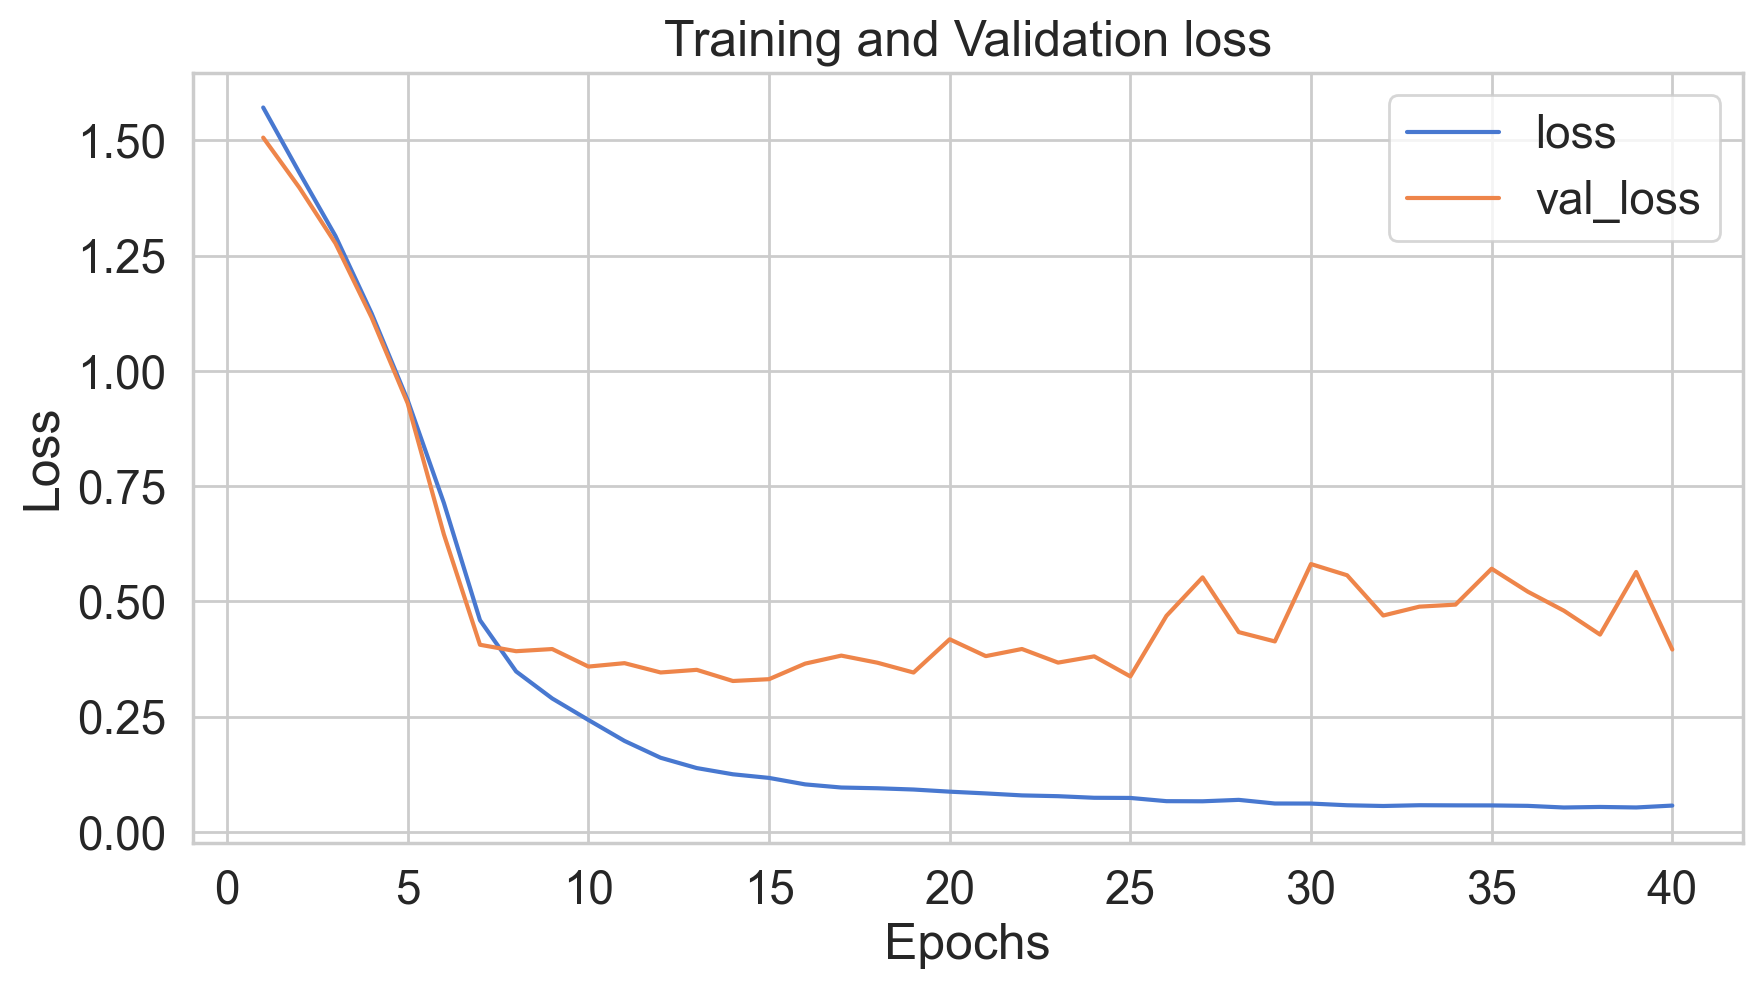

In [317]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_train)+1)
plt.figure(figsize=(10,5))
plt.plot(epochs, loss_train, label='loss')
plt.plot(epochs, loss_val, label='val_loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

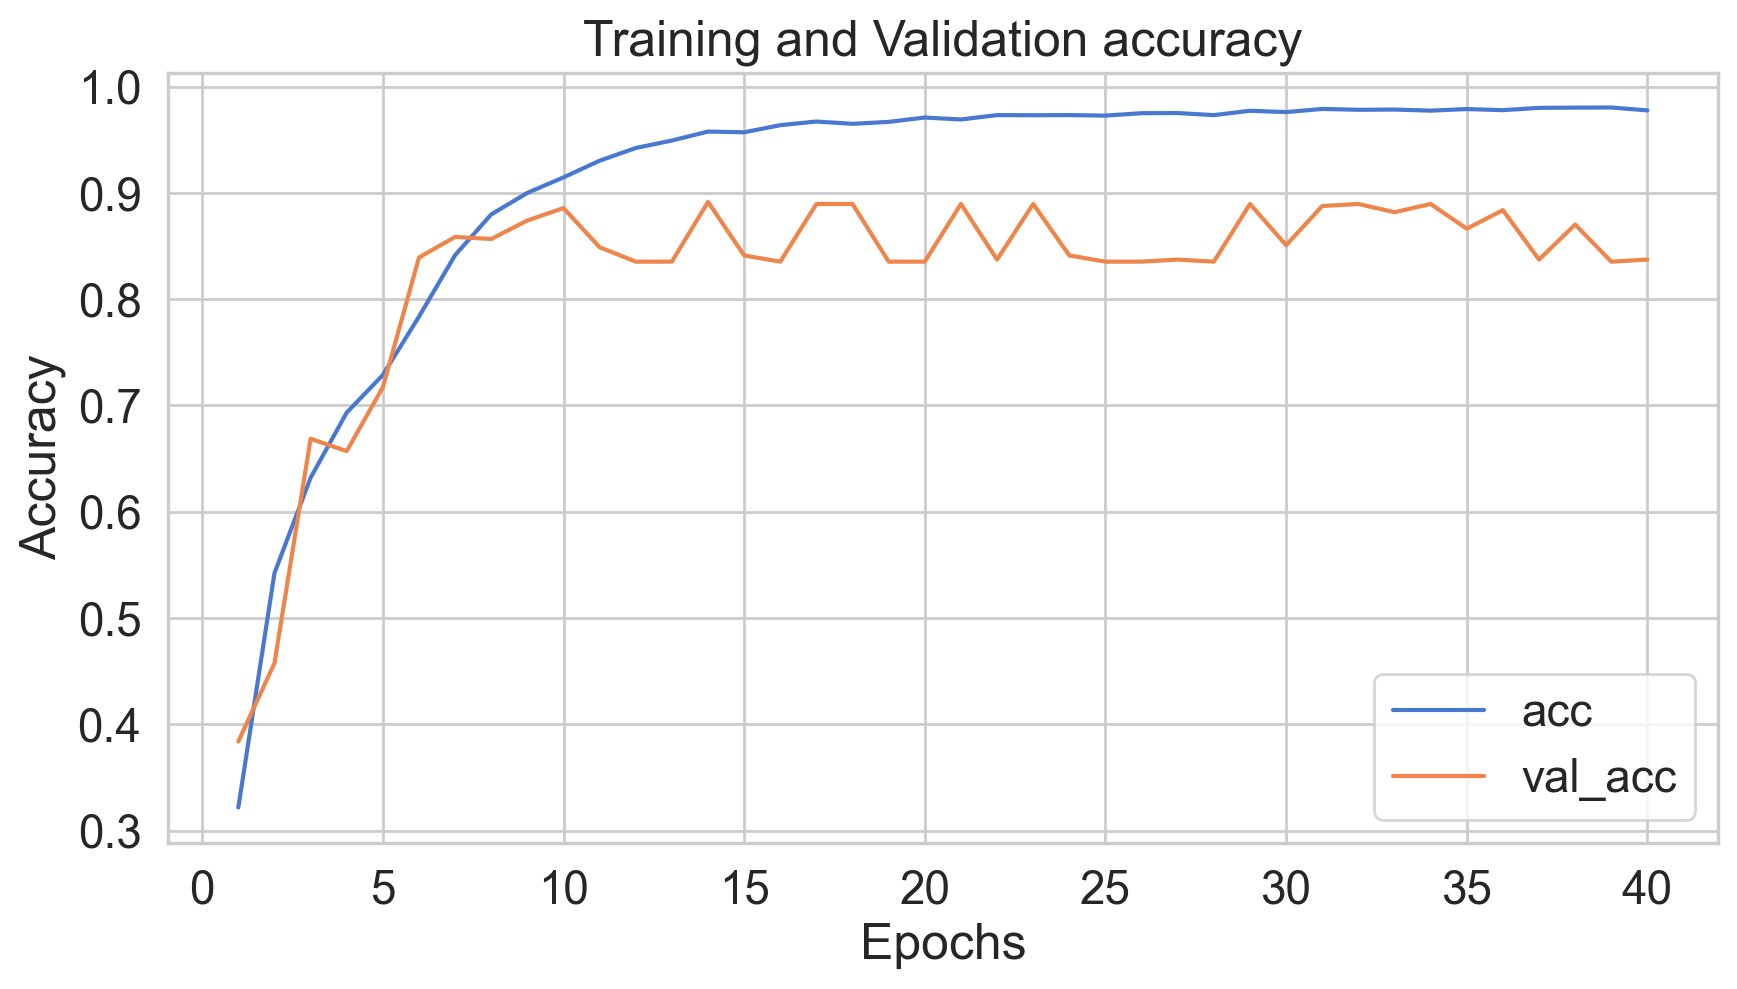

In [318]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,len(loss_train)+1)
plt.figure(figsize=(10,5))
plt.plot(epochs, accuracy_train, label='acc')
plt.plot(epochs, accuracy_val, label='val_acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CNN

Fit the CNN model, loss measured by cross-entroy. 

In [319]:
filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 5

In [320]:
model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dropout(0.4))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dropout(0.4))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 48, 64)            1216      
                                                                 
 batch_normalization_27 (Bat  (None, 48, 64)           256       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 48, 64)            0         
                                                                 
 dropout_24 (Dropout)        (None, 48, 64)            0         
                                                                 
 conv1d_28 (Conv1D)          (None, 46, 64)            12352     
                                                                 
 batch_normalization_28 (Bat  (None, 46, 64)           256       
 chNormalization)                                    

In [321]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])

In [322]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
history = model.fit(X_train, y_train,batch_size=128, epochs=200,callbacks=[callback],
                    validation_data=(X_validation, y_validation))

Epoch 1/200
69/69 [==============================] - 4s 39ms/step - loss: 0.7078 - accuracy: 0.7189 - val_loss: 0.9224 - val_accuracy: 0.6647
Epoch 2/200
69/69 [==============================] - 2s 34ms/step - loss: 0.1852 - accuracy: 0.9376 - val_loss: 0.4698 - val_accuracy: 0.8876
Epoch 3/200
69/69 [==============================] - 2s 34ms/step - loss: 0.1551 - accuracy: 0.9474 - val_loss: 0.3523 - val_accuracy: 0.8643
Epoch 4/200
69/69 [==============================] - 2s 34ms/step - loss: 0.1313 - accuracy: 0.9562 - val_loss: 0.2853 - val_accuracy: 0.8876
Epoch 5/200
69/69 [==============================] - 2s 34ms/step - loss: 0.1143 - accuracy: 0.9602 - val_loss: 0.2821 - val_accuracy: 0.9419
Epoch 6/200
69/69 [==============================] - 2s 34ms/step - loss: 0.1009 - accuracy: 0.9681 - val_loss: 0.2544 - val_accuracy: 0.9031
Epoch 7/200
69/69 [==============================] - 2s 34ms/step - loss: 0.0952 - accuracy: 0.9688 - val_loss: 0.3013 - val_accuracy: 0.8895
Epoch 

Test CNN model and get classification report on testing set.

In [323]:
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

80/80 [==============================] - 0s 2ms/step


In [324]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.93      0.79      0.85       521
           1       0.97      0.94      0.96       991
           2       0.99      1.00      1.00       283
           3       0.82      1.00      0.90       507
           4       1.00      1.00      1.00       256

    accuracy                           0.93      2558
   macro avg       0.94      0.95      0.94      2558
weighted avg       0.94      0.93      0.93      2558



Store HAR model for futher deployment on HAR app

In [325]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the model.
with open('./model/cnn.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/8k/zr2vzz8s3_x0rg8lzvz2lvth0000gn/T/tmpwqdo38x7/assets


INFO:tensorflow:Assets written to: /var/folders/8k/zr2vzz8s3_x0rg8lzvz2lvth0000gn/T/tmpwqdo38x7/assets
2022-09-12 12:53:50.188887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-09-12 12:53:50.188902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-09-12 12:53:50.190378: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/8k/zr2vzz8s3_x0rg8lzvz2lvth0000gn/T/tmpwqdo38x7
2022-09-12 12:53:50.196939: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-09-12 12:53:50.196959: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/8k/zr2vzz8s3_x0rg8lzvz2lvth0000gn/T/tmpwqdo38x7
2022-09-12 12:53:50.238802: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-09-12 12:53:50.349966: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

[[410  29   2  79   1]
 [ 29 933   0  29   0]
 [  0   0 283   0   0]
 [  0   0   0 507   0]
 [  0   0   0   0 256]]


Text(92.25, 0.5, 'true')

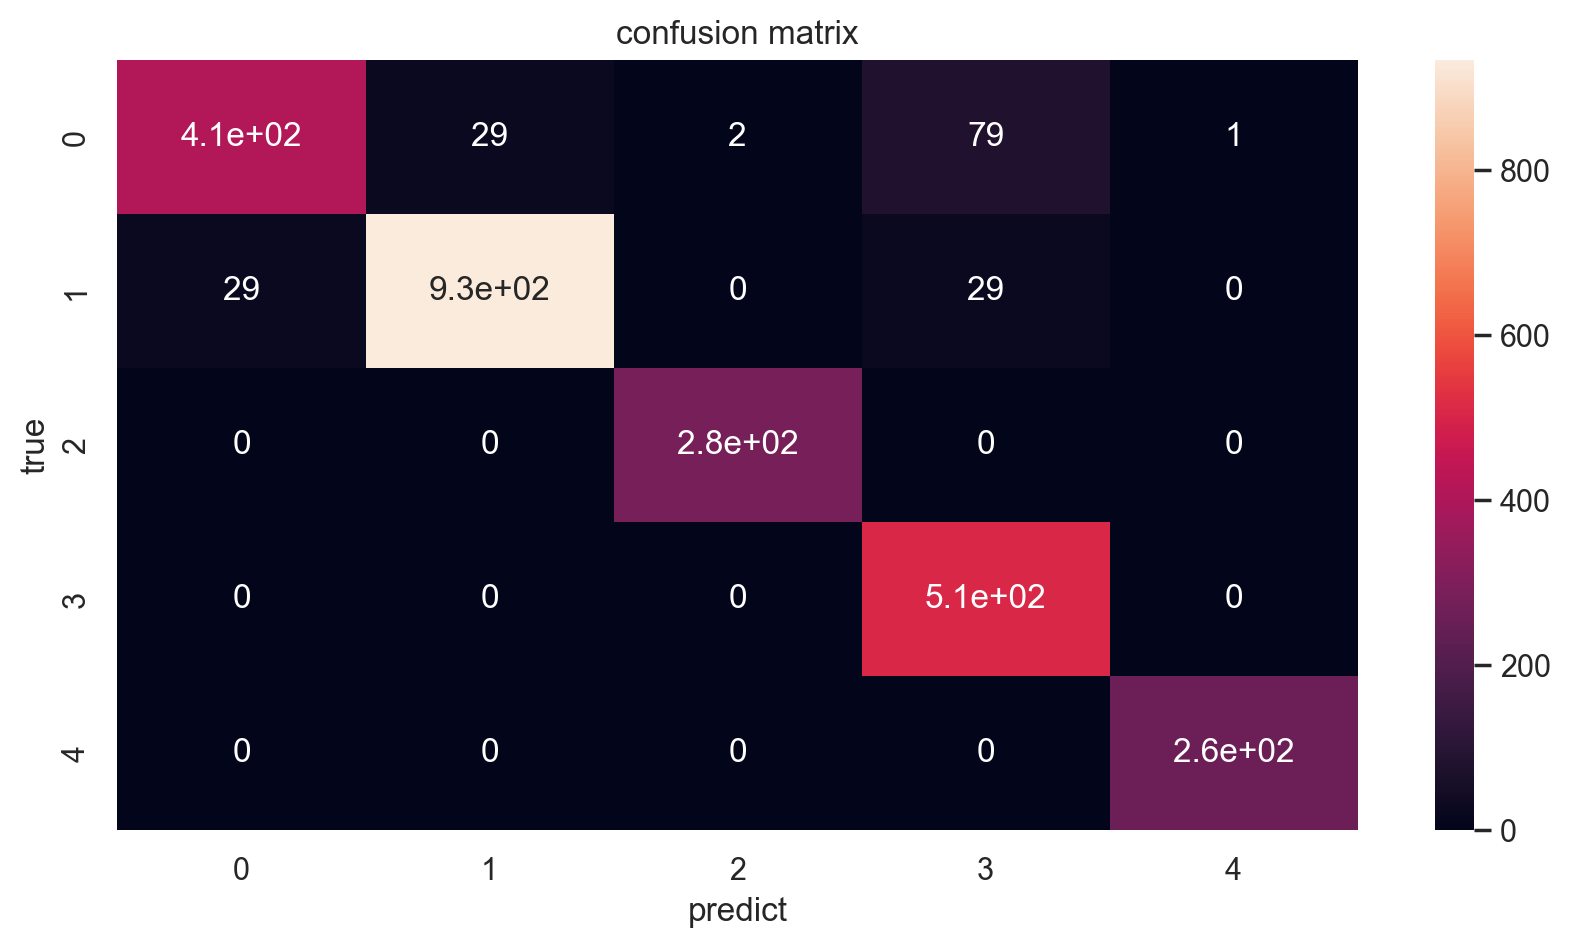

In [329]:
from sklearn.metrics import confusion_matrix
sns.set()

f,ax=plt.subplots(figsize=(10,5))
C2= confusion_matrix(y_true_labels, y_pred_labels, labels=[0, 1, 2,3,4])
print(C2) 
sns.heatmap(C2,annot=True,ax=ax) 

ax.set_title('confusion matrix')
ax.set_xlabel('predict')
ax.set_ylabel('true')